# Introduction

This notebook took a heavy inspiration to this awesome kaggle code: https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn/notebook.

Here I will add an anomaly detection to the work already done in that notebook.

In [1]:
#pip install tensorflow_gpu

In [1]:
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from matplotlib.pyplot import imshow
from keras.layers import Input
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import cv2
###
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
###
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shap
import scipy.io

C:\Users\Rober\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#pip freeze

In [16]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

#sns.palplot(colors_dark)
#sns.palplot(colors_green)
#sns.palplot(colors_red)

In [29]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
image_size = 224

In [30]:
# Loading images
X_train = []
y_train = []

for i in labels:
    folderPath = os.path.join('archive','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(labels.index(i))
        
for i in labels:
    folderPath = os.path.join('archive','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(labels.index(i))
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 109.93it/s]


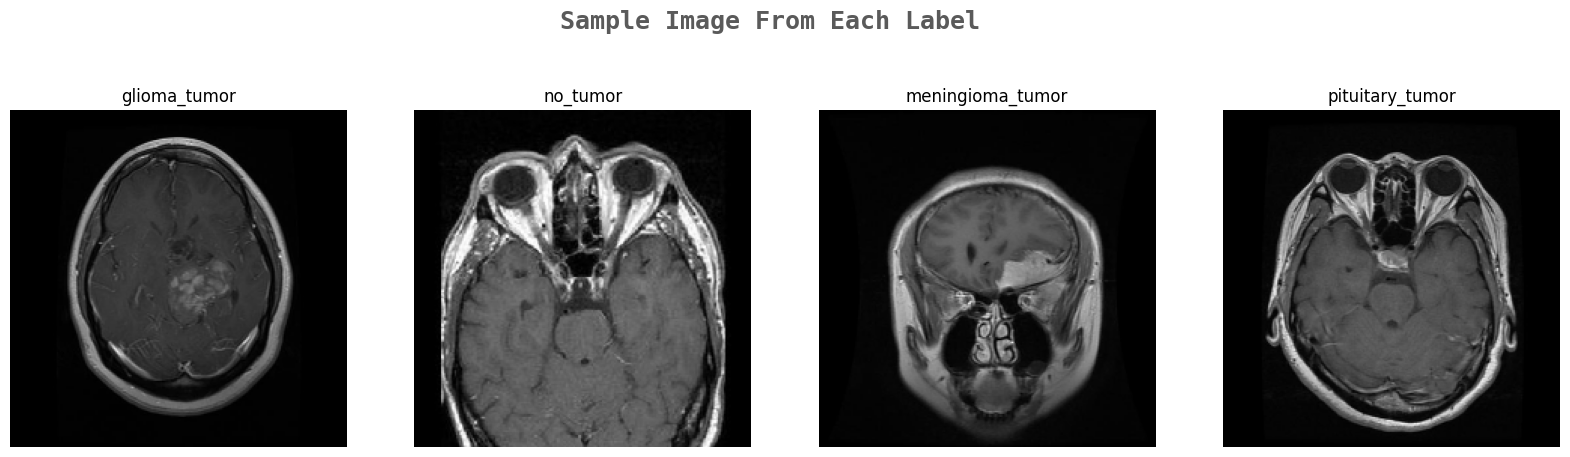

In [31]:
# seeing images
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in range(0,len(labels)):
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(labels[y_train[j]])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [32]:
X_train, y_train = shuffle(X_train,y_train, random_state=0)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=0)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [33]:
from keras.models import Model

from keras.applications.mobilenet import MobileNet
image_size = 224
base_model = MobileNet(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [34]:
# We added this that was not included in the kaggle code
# base_model.trainable = False -> we achieve a val_accuracy: 0.8113

In [35]:
model = base_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=base_model.input, outputs = model)

In [36]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [37]:
tensorboard = TensorBoard(log_dir = 'logs')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [38]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs = 12, verbose=1, batch_size=8,
                   callbacks=[tensorboard,reduce_lr])

Epoch 1/12
331/331 [==============================] - 30s 49ms/step - loss: 0.7317 - accuracy: 0.7760 - val_loss: 0.3522 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 2/12
331/331 [==============================] - 15s 44ms/step - loss: 0.3827 - accuracy: 0.8767 - val_loss: 0.3776 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 3/12
330/331 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.9174
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
331/331 [==============================] - 15s 45ms/step - loss: 0.2596 - accuracy: 0.9175 - val_loss: 0.4721 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/12
331/331 [==============================] - 15s 45ms/step - loss: 0.1159 - accuracy: 0.9591 - val_loss: 0.2168 - val_accuracy: 0.9320 - lr: 3.0000e-04
Epoch 5/12
331/331 [==============================] - 15s 45ms/step - loss: 0.0736 - accuracy: 0.9788 - val_loss: 0.1234 - val_accuracy: 0.9524 - lr: 3.0000e-04
Epoch 6/12
331/331 [==========================

In [43]:
import pickle
# when base_model.trainable = False
# model.save('keras/model_brain_non_trainable.keras')
# when base_model.trainable = True
model.save('keras/model_brain_trainable.keras')
with open('train_history_dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
# loading
with open('train_history_dict', "rb") as file_pi:
    history = pickle.load(file_pi)
#model = keras.models.load_model('keras/model_brain_trainable.keras')

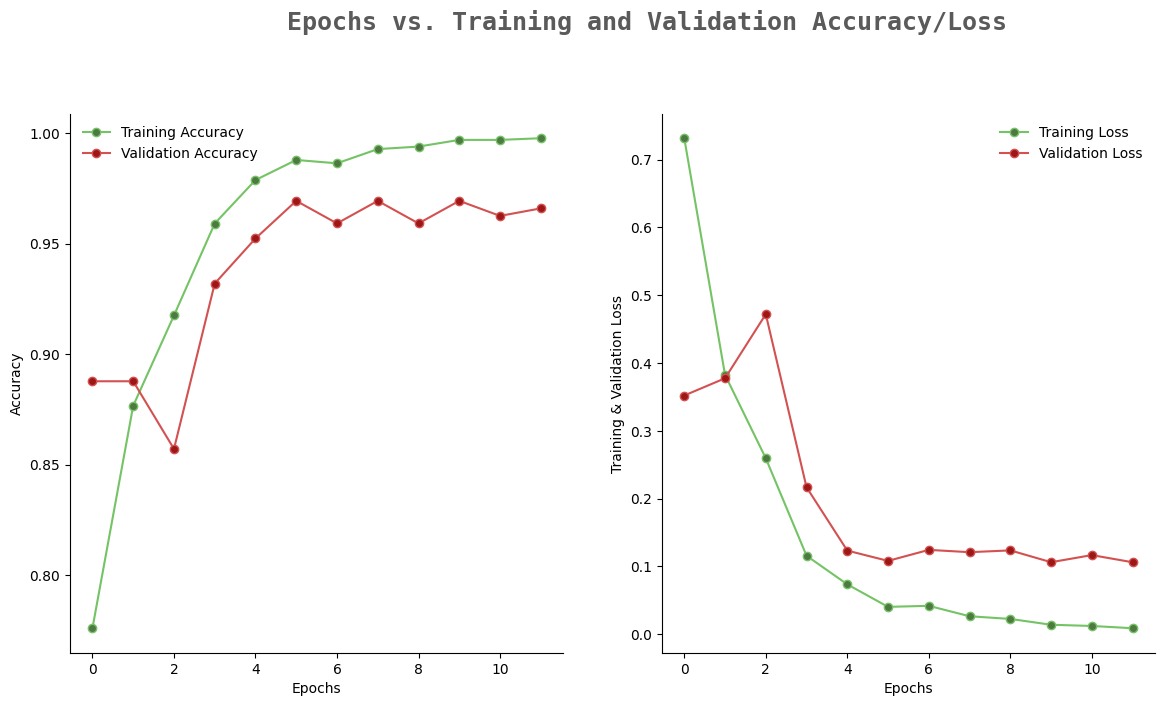

In [44]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# Making prediction on the test data

In [45]:
pred = model.predict(X_test)
pred

11/11 [==============================] - 1s 34ms/step


array([[4.6743598e-06, 4.1561968e-08, 1.4141444e-05, 9.9998105e-01],
       [3.0085614e-06, 2.6691080e-08, 4.9388582e-06, 9.9999213e-01],
       [9.4372554e-06, 9.7965394e-06, 4.3656964e-06, 9.9997640e-01],
       ...,
       [3.5681314e-06, 4.8799444e-07, 3.1201544e-05, 9.9996471e-01],
       [2.0431435e-01, 5.0878921e-06, 7.9564357e-01, 3.7005942e-05],
       [5.7556986e-06, 2.9400594e-06, 1.1428401e-05, 9.9997985e-01]],
      dtype=float32)

The number below are prediction for each picture in X_test the label: ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [46]:
pred = np.argmax(pred,axis=1)
pred 

array([3, 3, 3, 2, 0, 2, 2, 2, 1, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 3, 1, 2, 1, 2, 1, 2, 0, 3, 0,
       0, 0, 2, 2, 2, 0, 1, 3, 3, 3, 0, 3, 3, 1, 1, 0, 3, 0, 0, 3, 0, 1,
       1, 0, 3, 1, 0, 0, 2, 2, 2, 0, 3, 0, 2, 3, 0, 0, 0, 2, 3, 1, 0, 2,
       1, 0, 3, 2, 3, 1, 2, 0, 3, 0, 1, 0, 3, 0, 3, 0, 2, 2, 2, 0, 0, 3,
       1, 3, 2, 0, 2, 2, 1, 0, 2, 0, 3, 3, 1, 0, 0, 1, 0, 3, 3, 3, 1, 3,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0, 3, 2, 2, 3,
       2, 0, 3, 0, 0, 1, 2, 3, 1, 0, 2, 0, 1, 3, 3, 2, 0, 2, 0, 2, 3, 2,
       3, 2, 1, 3, 0, 0, 2, 3, 0, 0, 3, 3, 0, 2, 2, 3, 0, 1, 3, 2, 1, 2,
       0, 3, 1, 0, 3, 2, 0, 0, 3, 1, 2, 2, 3, 0, 2, 2, 3, 1, 3, 1, 1, 1,
       3, 2, 3, 2, 3, 1, 3, 2, 2, 2, 2, 1, 3, 0, 2, 2, 3, 2, 3, 1, 0, 3,
       0, 3, 2, 0, 3, 3, 0, 0, 0, 3, 0, 3, 0, 2, 1, 1, 2, 1, 0, 2, 2, 3,
       2, 2, 0, 0, 2, 3, 0, 3, 0, 3, 0, 2, 3, 2, 1, 0, 3, 3, 1, 1, 0, 3,
       0, 3, 1, 0, 3, 0, 2, 3, 3, 2, 2, 3, 2, 2, 3,

In [47]:
y_test_new = np.argmax(y_test,axis=1)
y_test_new

array([3, 3, 3, 2, 0, 2, 2, 2, 1, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 3, 1, 2, 1, 2, 1, 2, 0, 3, 0,
       0, 0, 2, 2, 2, 0, 1, 3, 3, 3, 0, 3, 3, 1, 1, 0, 3, 0, 0, 3, 0, 1,
       1, 0, 3, 1, 0, 0, 2, 2, 2, 0, 3, 0, 2, 3, 0, 0, 0, 2, 3, 1, 0, 2,
       1, 0, 3, 2, 3, 1, 2, 0, 3, 0, 1, 0, 3, 0, 3, 0, 2, 2, 2, 0, 0, 3,
       1, 3, 2, 0, 2, 2, 1, 0, 2, 0, 3, 3, 1, 0, 0, 1, 0, 3, 3, 3, 1, 3,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0, 3, 2, 2, 3,
       2, 0, 3, 0, 0, 1, 2, 3, 1, 0, 2, 0, 1, 3, 3, 2, 0, 2, 0, 2, 3, 2,
       3, 2, 1, 3, 0, 0, 2, 3, 0, 0, 3, 3, 0, 2, 2, 3, 0, 1, 3, 2, 1, 2,
       0, 3, 1, 0, 3, 2, 0, 0, 3, 1, 0, 2, 3, 0, 2, 2, 3, 1, 3, 1, 1, 0,
       3, 2, 3, 2, 3, 1, 3, 2, 2, 2, 2, 1, 3, 0, 0, 2, 3, 2, 3, 1, 0, 3,
       0, 3, 2, 0, 3, 3, 0, 0, 0, 3, 0, 3, 0, 2, 1, 1, 2, 1, 0, 0, 2, 3,
       2, 2, 0, 0, 2, 3, 0, 3, 0, 3, 0, 2, 3, 2, 1, 0, 3, 3, 1, 1, 0, 3,
       0, 3, 1, 0, 3, 0, 2, 3, 3, 2, 2, 3, 2, 2, 3,

# Anomaly detection

**Stayed tune for the anomaly detection**

no_tumor
AxesImage(shape=(224, 224, 3))


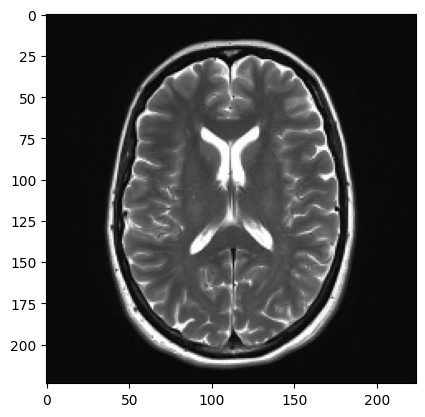

In [48]:
# finding in X_test a brain without a tumor
print(labels[y_test_new[8]])
print(imshow(X_test[8]))

In [50]:
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(224,224)", X_test[8].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=labels)

# here we explain 20 images using 5000 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(
X_test[1:20], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])


 92%|██████████████████████████████████████████████████████████████████████▋      | 4592/4998 [00:05<00:00, 784.63it/s]
                                                                                                                       
PartitionExplainer explainer:   5%|███▏                                                         | 1/19 [00:00<?, ?it/s]

  0%|                                                                                         | 0/4998 [00:00<?, ?it/s]

 44%|████████████████████████████████▉                                          | 2192/4998 [00:00<00:00, 19827.72it/s]

 84%|████████████████████████████████████████████████████████████████▌            | 4192/4998 [00:05<00:01, 707.08it/s]

5042it [00:07, 576.39it/s]                                                                                             

                          
PartitionExplainer explainer:  16%|████████▎                                            | 3/19 [00:26<01:43,  6.48s/it]

  0%| 

                          
PartitionExplainer explainer:  58%|██████████████████████████████                      | 11/19 [02:15<01:49, 13.65s/it]

  0%|                                                                                         | 0/4998 [00:00<?, ?it/s]

 40%|█████████████████████████████▉                                             | 1992/4998 [00:00<00:00, 10913.11it/s]

 62%|███████████████████████████████████████████████▋                             | 3092/4998 [00:03<00:02, 826.82it/s]

 72%|███████████████████████████████████████████████████████▎                     | 3592/4998 [00:04<00:02, 642.68it/s]

 78%|███████████████████████████████████████████████████████████▉                 | 3892/4998 [00:05<00:01, 569.49it/s]

 82%|███████████████████████████████████████████████████████████████              | 4092/4998 [00:05<00:01, 521.59it/s]

 85%|█████████████████████████████████████████████████████████████████▎           | 4242/4998 [00:06<00:01, 494.30it/s]

 87%|

5042it [00:08, 443.86it/s]                                                                                             

                          
PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▎  | 18/19 [03:56<00:14, 14.49s/it]

  0%|                                                                                         | 0/4998 [00:00<?, ?it/s]

 39%|█████████████████████████████▏                                             | 1942/4998 [00:00<00:00, 13397.75it/s]

 66%|██████████████████████████████████████████████████▋                          | 3292/4998 [00:03<00:02, 703.92it/s]

 78%|███████████████████████████████████████████████████████████▉                 | 3892/4998 [00:05<00:01, 560.06it/s]

 85%|█████████████████████████████████████████████████████████████████▎           | 4242/4998 [00:06<00:01, 502.04it/s]

 90%|█████████████████████████████████████████████████████████████████████▏       | 4492/4998 [00:07<00:01, 467.22it/s]

 93%|

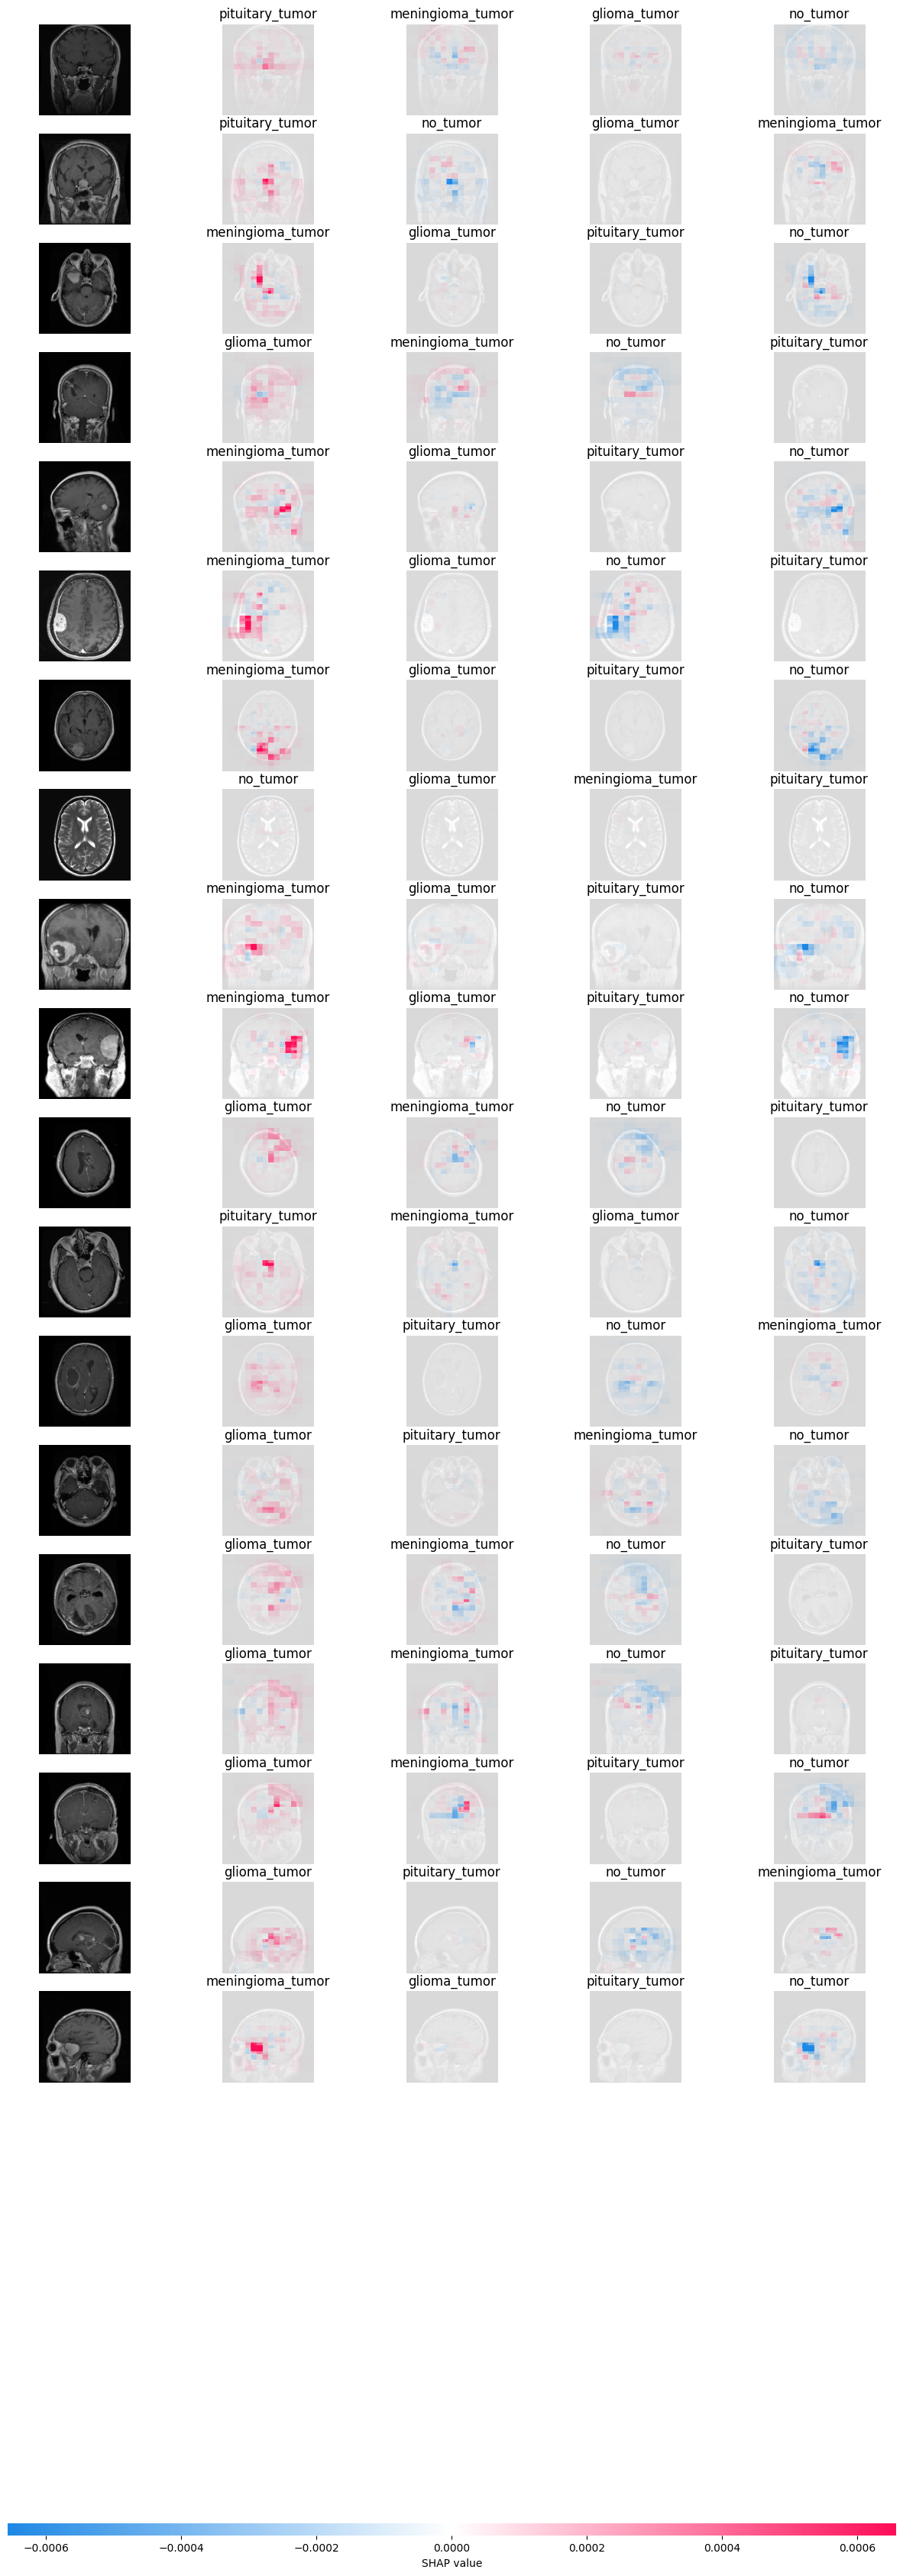

In [51]:
# output with shap values
shap.image_plot(shap_values_fine)

So, We not only create our model we can now understand why our model do the prediction that it does!